# Agentic RAG From Scratch: Building with LangGraph and Open-Source Models

In this notebook, we'll look under the hood of `create_agent` and build an agentic RAG application **from scratch** using LangGraph's low-level primitives and locally-hosted open-source models.

**Learning Objectives:**
- Understand LangGraph's core constructs: StateGraph, nodes, edges, and conditional routing
- Build a ReAct agent from scratch without high-level abstractions
- Use Ollama to run open-source models locally (gpt-oss:20b + embeddinggemma)
- Transition from `aimakerspace` utilities to the LangChain ecosystem

## Table of Contents:

- **Breakout Room #1:** LangGraph Fundamentals & Building Agents from Scratch
  - Task 1: Dependencies & Ollama Setup
  - Task 2: LangGraph Core Concepts (StateGraph, Nodes, Edges)
  - Task 3: Building a ReAct Agent from Scratch
  - Task 4: Adding Tools to Your Agent
  - Question #1 & Question #2
  - Activity #1: Implement a Custom Routing Function

- **Breakout Room #2:** Agentic RAG with Local Models
  - Task 5: Loading & Chunking with LangChain
  - Task 6: Setting up Qdrant with Local Embeddings
  - Task 7: Creating a RAG Tool
  - Task 8: Building Agentic RAG from Scratch
  - Question #3 & Question #4
  - Activity #2: Extend the Agent with Memory

---
# Breakout Room #1
## LangGraph Fundamentals & Building Agents from Scratch

## Task 1: Dependencies & Ollama Setup

Before we begin, make sure you have:

1. **Ollama installed** - Download from [ollama.com](https://ollama.com/)
2. **Ollama running** - Start with `ollama serve` in a terminal
3. **Models pulled** - Run these commands:

```bash
# Chat model for reasoning and generation (~12GB)
ollama pull gpt-oss:20b

# Embedding model for RAG (~622MB)
ollama pull embeddinggemma
```

> **Note**: If you don't have enough RAM/VRAM for `gpt-oss:20b` (requires 16GB+ VRAM or 24GB+ RAM), you can substitute with `llama3.2:3b` or another smaller model.

**📚 Documentation:**
- [Ollama Installation Guide](https://ollama.com/download)
- [gpt-oss Model Card](https://ollama.com/library/gpt-oss)
- [EmbeddingGemma Model Card](https://ollama.com/library/embeddinggemma)
- [langchain-ollama Integration](https://python.langchain.com/docs/integrations/providers/ollama/)

In [1]:
# Core imports we'll use throughout the notebook
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [12]:
# Verify Ollama is running and models are available
from langchain_ollama import ChatOllama, OllamaEmbeddings

# Test connection to Ollama
try:
    test_llm = ChatOllama(model="gemma3:4b", temperature=0)
    test_response = test_llm.invoke("Say 'Ollama is working!' in exactly 3 words.")
    print(f"Chat Model Test: {test_response.content}")
    
    test_embeddings = OllamaEmbeddings(model="embeddinggemma")
    test_vector = test_embeddings.embed_query("test")
    print(f"Embedding Model Test: Vector dimension = {len(test_vector)}")
    print("\nOllama is ready!")
except Exception as e:
    print(f"Error connecting to Ollama: {e}")
    print("\nMake sure:")
    print("1. Ollama is installed: https://ollama.com/")
    print("2. Ollama is running: 'ollama serve'")
    print("3. Models are pulled: 'ollama pull gemma3:4b' and 'ollama pull embeddinggemma'")

Chat Model Test: Ollama is working!
Embedding Model Test: Vector dimension = 768

Ollama is ready!


## Task 2: LangGraph Core Concepts

In Session 3, we used `create_agent` which abstracts away the complexity. Now let's understand what's happening under the hood!

### LangGraph models workflows as **graphs** with three key components:

### 1. State
A shared data structure that represents the current snapshot of your application:

```python
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]  # Conversation history
```

The `add_messages` **reducer** ensures new messages are appended (not replaced) when the state updates.

### 2. Nodes
Python functions that encode the logic of your agent:
- Receive the current state
- Perform computation or side-effects
- Return an updated state

### 3. Edges
Functions that determine which node to execute next:
- **Normal edges**: Always go to a specific node
- **Conditional edges**: Choose the next node based on state

**📚 Documentation:**
- [LangGraph Low-Level Concepts](https://langchain-ai.github.io/langgraph/concepts/low_level/)
- [LangGraph Quickstart](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [StateGraph API Reference](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph)

In [13]:
# Let's build our first LangGraph workflow - a simple echo graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# Step 1: Define the State
class SimpleState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 2: Define Nodes (functions that process state)
def echo_node(state: SimpleState):
    """A simple node that echoes the last message."""
    last_message = state["messages"][-1]
    echo_response = AIMessage(content=f"You said: {last_message.content}")
    return {"messages": [echo_response]}

# Step 3: Build the Graph
echo_graph = StateGraph(SimpleState)

# Add nodes
echo_graph.add_node("echo", echo_node)

# Add edges (START -> echo -> END)
echo_graph.add_edge(START, "echo")
echo_graph.add_edge("echo", END)

# Compile the graph
echo_app = echo_graph.compile()

print("Simple echo graph created!")

Simple echo graph created!


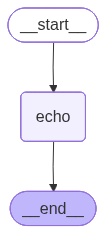

In [14]:
# Visualize the graph structure
try:
    from IPython.display import display, Image
    display(Image(echo_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(echo_app.get_graph().draw_ascii())

In [15]:
# Test the echo graph
result = echo_app.invoke({"messages": [HumanMessage(content="Hello, LangGraph!")]})

print("Conversation:")
for msg in result["messages"]:
    role = "Human" if isinstance(msg, HumanMessage) else "AI"
    print(f"  [{role}]: {msg.content}")

Conversation:
  [Human]: Hello, LangGraph!
  [AI]: You said: Hello, LangGraph!


## Task 3: Building a ReAct Agent from Scratch

Now let's build something more sophisticated: a **ReAct agent** that can:
1. **Reason** about what to do
2. **Act** by calling tools
3. **Observe** results
4. **Repeat** until done

This is exactly what `create_agent` does under the hood. Let's build it ourselves!

### The Agent Loop Architecture

```
                    ┌──────────────┐
                    │    START     │
                    └──────┬───────┘
                           │
                           ▼
                    ┌──────────────┐
             ┌─────►│    agent     │◄────────┐
             │      │  (call LLM)  │         │
             │      └──────┬───────┘         │
             │             │                 │
             │             ▼                 │
             │      ┌──────────────┐         │
             │      │ should_      │         │
             │      │ continue?    │         │
             │      └──────┬───────┘         │
             │             │                 │
             │    tool_calls?                │
             │     │           │             │
             │    YES         NO             │
             │     │           │             │
             │     ▼           ▼             │
             │ ┌────────┐  ┌───────┐         │
             │ │ tools  │  │  END  │         │
             └─┤(execute│  └───────┘         │
               │ tools) ├────────────────────┘
               └────────┘
```

**📚 Documentation:**
- [How to create a ReAct agent from scratch](https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/)
- [ReAct Agent Conceptual Guide](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent)

In [30]:
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

# Step 1: Define the Agent State
class AgentState(TypedDict):
    """The state of our agent - just a list of messages."""
    messages: Annotated[list[BaseMessage], add_messages]

print("AgentState defined with messages field")

AgentState defined with messages field


In [31]:
# Step 2: Initialize our local LLM with Ollama
llm = ChatOllama(
    model="llama3.2:3b",
    temperature=0,  # Deterministic for reproducibility
)

print(f"LLM initialized: {llm.model}")

LLM initialized: llama3.2:3b


## Task 4: Adding Tools to Your Agent

Tools are functions that the agent can call. We use the `@tool` decorator and **bind** them to the LLM.

**📚 Documentation:**
- [LangChain Tools Conceptual Guide](https://python.langchain.com/docs/concepts/tools/)
- [@tool Decorator Reference](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html)
- [ToolNode Prebuilt](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode)

In [32]:
# Step 3: Define Tools
@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool list
tools = [calculate, get_current_time]

# Bind tools to the LLM - this tells the LLM about available tools
llm_with_tools = llm.bind_tools(tools)

print("Tools defined and bound to LLM:")
for t in tools:
    print(f"  - {t.name}: {t.description[:50]}...")

Tools defined and bound to LLM:
  - calculate: Evaluate a mathematical expression. Use this for a...
  - get_current_time: Get the current date and time. Use this when the u...


In [79]:
# Step 4: Define the Agent Node (calls the LLM)
SYSTEM_PROMPT = """You are a helpful assistant that can perform calculations and tell the time.
Always use the available tools when appropriate.
Be concise in your responses."""

def agent_node(state: AgentState):
    """The agent node - calls the LLM with the current conversation."""
    # Prepare messages with system prompt
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    
    # Call the LLM
    response = llm_with_tools.invoke(messages)
    
    # Return the response to be added to state
    return {"messages": [response]}

print("Agent node defined")

Agent node defined


In [34]:
# Step 5: Define the Tool Node (executes tools)
# We can use LangGraph's prebuilt ToolNode for convenience
tool_node = ToolNode(tools)

print("Tool node created using ToolNode prebuilt")

Tool node created using ToolNode prebuilt


In [35]:
# Step 6: Define the Conditional Edge (routing logic)
def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """Determine whether to call tools or end the conversation."""
    last_message = state["messages"][-1]
    
    # If the LLM made tool calls, route to tools node
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Otherwise, end the conversation
    return "end"

print("Conditional routing function defined")

Conditional routing function defined


In [36]:
# Step 7: Build the Graph!
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

# Set the entry point
workflow.add_edge(START, "agent")

# Add conditional edge from agent
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",  # If should_continue returns "tools", go to tools node
        "end": END         # If should_continue returns "end", finish
    }
)

# Add edge from tools back to agent (the loop!)
workflow.add_edge("tools", "agent")

# Compile the graph
agent = workflow.compile()

print("ReAct agent built from scratch!")

ReAct agent built from scratch!


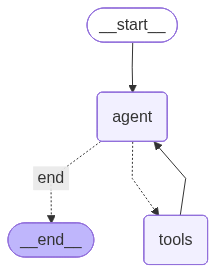

In [37]:
# Visualize our agent
try:
    from IPython.display import display, Image
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(agent.get_graph().draw_ascii())

In [38]:
# Test our agent!
print("Testing our from-scratch agent:")
print("=" * 50)

response = agent.invoke({"messages": [HumanMessage(content="What is 25 * 48?")]})

print("\nConversation:")
for msg in response["messages"]:
    msg_type = type(msg).__name__
    content = msg.content if msg.content else f"[Tool calls: {msg.tool_calls}]" if hasattr(msg, 'tool_calls') and msg.tool_calls else "[No content]"
    print(f"  [{msg_type}]: {content[:200]}")

Testing our from-scratch agent:

Conversation:
  [HumanMessage]: What is 25 * 48?
  [AIMessage]: [Tool calls: [{'name': 'calculate', 'args': {'expression': '25 * 48'}, 'id': '8b6c6017-9d71-477a-9df4-ad189ba087c6', 'type': 'tool_call'}]]
  [ToolMessage]: The result of 25 * 48 is 1200
  [AIMessage]: 1200


In [39]:
# Test with multiple tools
print("Testing with multiple tool calls:")
print("=" * 50)

response = agent.invoke({
    "messages": [HumanMessage(content="What time is it, and what is 100 divided by the current hour?")]
})

print("\nFinal response:")
print(response["messages"][-1].content)

Testing with multiple tool calls:

Final response:
I apologize for the error. Since I'm a text-based AI assistant, I don't have real-time access to the current time. However, I can tell you that the hour is 9.

Now, let's calculate 100 divided by 9:

100 / 9 = 11.1111


In [41]:
# Stream the agent's execution to see it step by step
print("Streaming agent execution:")
print("=" * 50)

for chunk in agent.stream(
    {"messages": [HumanMessage(content="What time is it, and what is 100 divided by the current hour?")]},
    stream_mode="updates"
):
    for node_name, values in chunk.items():
        print(f"\n[Node: {node_name}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(f"  Content: {msg.content[:200]}")
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"  Tool calls: {[tc['name'] for tc in msg.tool_calls]}")

Streaming agent execution:

[Node: agent]
  Tool calls: ['get_current_time', 'calculate']

[Node: tools]
  Content: The current date and time is: 2026-01-25 09:29:42
  Content: Error evaluating expression: name 'get_current_time' is not defined

[Node: agent]
  Content: I apologize for the error. Since I'm a text-based AI assistant, I don't have real-time access to the current time. However, I can tell you that the hour is 9.

Now, let's calculate 100 divided by 9:
1


---
## ❓ Question #1:

In our from-scratch agent, we defined a `should_continue` function that returns either `"tools"` or `"end"`. How does this compare to how `create_agent` handles the same decision? What additional logic might `create_agent` include that we didn't implement?

##### Answer:
*Your answer here*

The `should_continue` function we implemented is more flexible compared to `create_agent`. Specifically `create_agent` will conitnue the loop only if there's tool calls; while `should_continue` gives us full control of the routing and branching logic, for example we can route to custom nodes besides tool node, or route to differnt node based on state of currnet node.

`create_agent` comes with some built-in production ready features that we didn't iplement, such as error handling (e.g., for tool call failure), recursion limits to prevent infinte loop etc.

## ❓ Question #2:

We used `ToolNode` from `langgraph.prebuilt` to execute tools. Looking at the tool execution flow, what would happen if we wanted to add logging, error handling, or rate limiting to tool execution? How would building our own tool node give us more control?

##### Answer:
Prebuilt `ToolNode` has `handle_tool_errors` field to enable error handling.
If we want to add logging/rate limiting for tool execution, the prebuilt `ToolNode` will not be sufficient. We generally have two options:

- Add new nodes dedicated to logging/rate limiting for the `ToolNode`. For example, we can add a pre-processing node before `ToolNode` for logging and rate limiting, we can also add post-processing node to add extra logging.

- Add a new custom node for tool calling, which handles logging, error handling, rate limiting in addition to the basic tool calling function.

Building our own tool node give us control over every step of the tool execution, e.g., do logging/rate limiting/input validation before tool execution, handle error for execution, etc. 

---
## 🏗️ Activity #1: Implement a Custom Routing Function

Extend the agent by implementing a **custom routing function** that adds more sophisticated logic.

Ideas:
- Add a maximum iteration limit to prevent infinite loops
- Route to different nodes based on the type of tool being called
- Add a "thinking" step before tool execution

Requirements:
1. Modify the `should_continue` function or create a new one
2. Add any new nodes if needed
3. Rebuild and test the agent

**📚 Documentation:**
- [Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)
- [How to create branches for parallel node execution](https://langchain-ai.github.io/langgraph/how-tos/branching/)

We'll implement the following for this activity:

- Keep a iteration_count and a MAX_ITERATIONS of 5. iteration_count will increment whenever we reach the agent node, and we will check if we have reached the limit.
- Split the two tools into two tool node, and add a conditional edge `route_by_tool` with custom logic to route to either or both tool, depending on which tool agent node decides to invoke. When both tools are selected, they can be executed in parallel.
- Add a thinking node before tool execution to log which tool(s) to call, agent node have a conditional edge `custom_should_continue` that will either route to the thinking node or the end node, depending on if any tool call is needed.


In [107]:
MAX_ITERATIONS = 5

from typing import Annotated, TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage


# Example: Add iteration tracking to prevent infinite loops
class AgentStateWithCounter(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    iteration_count: int

llm_with_tools = llm.bind_tools([get_current_time, calculate])

# Define the nodes
time_tool_node = ToolNode(tools=[get_current_time])
calc_tool_node = ToolNode(tools=[calculate])


def agent_node(state: AgentStateWithCounter):
    if state.get("iteration_count", 0) >= MAX_ITERATIONS:
        return {
            "messages": [AIMessage(content="Max iterations reached. Stopping here.")],
            "iteration_count": state["iteration_count"]
        }

    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {
        "messages": [response],
        "iteration_count": state["iteration_count"] + 1
    }

def thinking_node(state: AgentStateWithCounter):
    last_message = state["messages"][-1]
    print(f"Think node: Thinking about which tool to call...")
    for tool_call in last_message.tool_calls:
        print(f"  - {tool_call['name']}")
    return {"messages": []}

## Custom routing function
def custom_should_continue(state: AgentStateWithCounter) -> Literal["thinking", "end"]:
    # if (state.get("iteration_count", 0) >= MAX_ITERATIONS):
    #     print(f"Iteration {state['iteration_count']} reached max iterations. Ending conversation.")
    #     return "end"

    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "thinking"
    return "end"

def route_by_tool(state: AgentStateWithCounter) -> list[str]:
    """
    Route to tool nodes based on tool calls.
    """
    last_message = state["messages"][-1]

    nodes = []
    for tool in last_message.tool_calls:
        if tool["name"] == "get_current_time":
            print("Routing to time_tool_node")
            nodes.append("time_tool_node")
        elif tool["name"] == "calculate":
            print("Routing to calc_tool_node")
            nodes.append("calc_tool_node")
    return nodes

## Build the graph
workflow = StateGraph(AgentStateWithCounter)

workflow.add_node("agent", agent_node)
workflow.add_node("thinking", thinking_node)
workflow.add_node("time_tools", time_tool_node)
workflow.add_node("calc_tools", calc_tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", custom_should_continue, {"thinking": "thinking", "end": END})
workflow.add_conditional_edges("thinking", route_by_tool, {"time_tool_node": "time_tools", "calc_tool_node": "calc_tools"})

workflow.add_edge("time_tools", "agent")
workflow.add_edge("calc_tools", "agent")

# Build your custom agent
custom_agent = workflow.compile()

print("Custom agent built!")

Custom agent built!


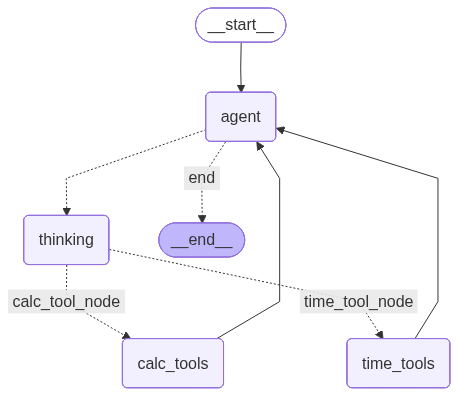

In [108]:
# Visualize our agent
try:
    from IPython.display import display, Image
    display(Image(custom_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(agent.get_graph().draw_ascii())

In [109]:
# Test 1: Only calculate tool
print("=" * 50)
print("TEST 1: Calculate only")
print("=" * 50)
response = custom_agent.invoke({
    "messages": [HumanMessage(content="What is 25 * 4?")],
    "iteration_count": 0
})
print(f"Final: {response['messages'][-1].content}")
print(f"Iterations: {response['iteration_count']}")


TEST 1: Calculate only
Think node: Thinking about which tool to call...
  - calculate
Routing to calc_tool_node
Final: 100
Iterations: 2


In [110]:
print("\n" + "=" * 50)
print("TEST 2: Time only")
print("=" * 50)
response = custom_agent.invoke({
    "messages": [HumanMessage(content="What time is it?")],
    "iteration_count": 0
})
print(f"Final: {response['messages'][-1].content}")
print(f"Iterations: {response['iteration_count']}")



TEST 2: Time only
Think node: Thinking about which tool to call...
  - get_current_time
Routing to time_tool_node
Final: It's currently 6:39 PM.
Iterations: 2


In [111]:
# Test 3: Both tools (should route to both in parallel)
print("\n" + "=" * 50)
print("TEST 3: Both tools (parallel)")
print("=" * 50)
response = custom_agent.invoke({
    "messages": [HumanMessage(content="What time is it and what is 100 / 5?")],
    "iteration_count": 0
})
print(f"Final: {response['messages'][-1].content}")
print(f"Iterations: {response['iteration_count']}")



TEST 3: Both tools (parallel)
Think node: Thinking about which tool to call...
  - get_current_time
  - calculate
Routing to time_tool_node
Routing to calc_tool_node
Final: The result of 100 / 5 is 20.0 

Current Time: 2026-01-25 18:39:41
Iterations: 2


In [112]:
# Test 4: No tool needed (should go directly to END)
print("\n" + "=" * 50)
print("TEST 4: No tools needed")
print("=" * 50)
response = custom_agent.invoke({
    "messages": [HumanMessage(content="Hello, how are you?")],
    "iteration_count": 0
})
print(f"Final: {response['messages'][-1].content}")
print(f"Iterations: {response['iteration_count']}")



TEST 4: No tools needed
Think node: Thinking about which tool to call...
  - get_current_time
Routing to time_tool_node
Final: I'm functioning properly. How can I assist you today?
Iterations: 2


In [113]:
# Test 5: Max iterations (start at 4, should stop at 5)
print("\n" + "=" * 50)
print("TEST 5: Max iterations")
print("=" * 50)
response = custom_agent.invoke({
    "messages": [HumanMessage(content="What is 1+1? What is 2+2?")],
    "iteration_count": 4  # Start near max
})
print(f"Final: {response['messages'][-1].content}")
print(f"Iterations: {response['iteration_count']}")



TEST 5: Max iterations
Think node: Thinking about which tool to call...
  - calculate
  - calculate
Routing to calc_tool_node
Routing to calc_tool_node
Final: Max iterations reached. Stopping here.
Iterations: 5


---
# Breakout Room #2
## Agentic RAG with Local Models

Now let's build a full **Agentic RAG** system from scratch using our local models!

We'll transition from the `aimakerspace` utilities to the **LangChain ecosystem**:

| Task | aimakerspace | LangChain |
|------|--------------|----------|
| Load Documents | `TextFileLoader` | `TextLoader` |
| Split Text | `CharacterTextSplitter` | `RecursiveCharacterTextSplitter` |
| Embeddings | Custom | `OllamaEmbeddings` |

## Task 5: Loading & Chunking with LangChain

Let's use LangChain's document loaders and text splitters.

**📚 Documentation:**
- [Document Loaders Conceptual Guide](https://python.langchain.com/docs/concepts/document_loaders/)
- [TextLoader Reference](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.text.TextLoader.html)
- [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)
- [Text Splitters Conceptual Guide](https://python.langchain.com/docs/concepts/text_splitters/)

In [114]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load the document using LangChain's TextLoader
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

print(f"Loaded {len(documents)} document(s)")
print(f"Total characters: {sum(len(doc.page_content) for doc in documents):,}")
print(f"\nDocument metadata: {documents[0].metadata}")

Loaded 1 document(s)
Total characters: 16,206

Document metadata: {'source': 'data/HealthWellnessGuide.txt'}


In [115]:
# Split documents using RecursiveCharacterTextSplitter
# This is more sophisticated than simple character splitting!

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
    # Default separators: ["\n\n", "\n", " ", ""]
    # Tries to keep paragraphs, then sentences, then words together
)

chunks = text_splitter.split_documents(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk (first 300 chars):")
print("-" * 50)
print(chunks[0].page_content[:300] + "...")

Split into 45 chunks

Sample chunk (first 300 chars):
--------------------------------------------------
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things you can do for your health. Regular physical activity can improve your brain health, help manage weigh...


## Task 6: Setting up Qdrant with Local Embeddings

Now we'll use **OllamaEmbeddings** with the `embeddinggemma` model - completely local!

**📚 Documentation:**
- [OllamaEmbeddings Reference](https://python.langchain.com/api_reference/ollama/embeddings/langchain_ollama.embeddings.OllamaEmbeddings.html)
- [Qdrant Vector Store Integration](https://python.langchain.com/docs/integrations/vectorstores/qdrant/)
- [Embedding Models Conceptual Guide](https://python.langchain.com/docs/concepts/embedding_models/)
- [EmbeddingGemma Overview (Google)](https://ai.google.dev/gemma/docs/embeddinggemma)

In [116]:
from langchain_ollama import OllamaEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize local embedding model
embedding_model = OllamaEmbeddings(model="embeddinggemma")

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")
print(f"Using local model: embeddinggemma")

Embedding dimension: 768
Using local model: embeddinggemma


In [117]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our wellness documents
collection_name = "wellness_knowledge_base_local"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

Created collection: wellness_knowledge_base_local


In [118]:
# Create vector store and add documents
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
print("Adding documents to vector store (this may take a moment with local embeddings)...")
vector_store.add_documents(chunks)
print(f"Added {len(chunks)} documents to vector store")

Adding documents to vector store (this may take a moment with local embeddings)...
Added 45 documents to vector store


In [119]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("How can I improve my sleep?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
Chapter 8: Improving Sleep Quality

Sleep hygiene refers to habits and practices that promote consistent, quality sleep.

Essential sleep hygiene practices:
- Maintain a consistent sleep schedule, eve...

--- Document 2 ---
Creating an optimal sleep environment:
- Temperature: 65-68 degrees Fahrenheit (18-20 Celsius)
- Darkness: Use blackout curtains or a sleep mask
- Quiet: Consider white noise machines or earplugs
- Co...

--- Document 3 ---
Types of insomnia:
- Acute insomnia: Short-term, often triggered by stress or life events
- Chronic insomnia: Long-term, occurring at least 3 nights per week for 3 months or more

Natural remedies for...


## Task 7: Creating a RAG Tool

Now let's wrap our retriever as a tool that the agent can use.

In [120]:
@tool
def search_wellness_knowledge(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips
    
    Args:
        query: The search query to find relevant wellness information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"RAG tool created: {search_wellness_knowledge.name}")

RAG tool created: search_wellness_knowledge


## Task 8: Building Agentic RAG from Scratch

Now let's put it all together - a complete agentic RAG system built from scratch!

In [ ]:
# Define all tools for our RAG agent
rag_tools = [search_wellness_knowledge, calculate, get_current_time]

# Bind tools to the LLM
rag_llm_with_tools = llm.bind_tools(rag_tools)

print("Tools for RAG agent:")
for t in rag_tools:
    print(f"  - {t.name}")

Tools for RAG agent:
  - search_wellness_knowledge
  - calculate
  - get_current_time


In [122]:
# Define the RAG agent components
RAG_SYSTEM_PROMPT = """You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. ALWAYS search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable."""

def rag_agent_node(state: AgentState):
    """The RAG agent node - calls the LLM with wellness system prompt."""
    messages = [SystemMessage(content=RAG_SYSTEM_PROMPT)] + state["messages"]
    response = rag_llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Create tool node for RAG tools
rag_tool_node = ToolNode(rag_tools)

print("RAG agent node defined")

RAG agent node defined


In [123]:
# Build the RAG agent graph
rag_workflow = StateGraph(AgentState)

# Add nodes
rag_workflow.add_node("agent", rag_agent_node)
rag_workflow.add_node("tools", rag_tool_node)

# Set entry point
rag_workflow.add_edge(START, "agent")

# Add conditional edge
rag_workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "end": END}
)

# Add edge from tools back to agent
rag_workflow.add_edge("tools", "agent")

# Compile
rag_agent = rag_workflow.compile()

print("Agentic RAG built from scratch!")

Agentic RAG built from scratch!


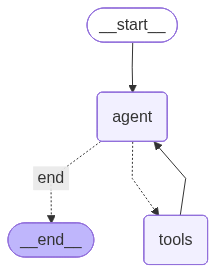

In [124]:
# Visualize the RAG agent
try:
    from IPython.display import display, Image
    display(Image(rag_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure:")
    print(rag_agent.get_graph().draw_ascii())

In [125]:
# Test the RAG agent
print("Testing Agentic RAG (with local models):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What are some tips for better sleep?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Agentic RAG (with local models):

Final Response:
To provide you with tips for better sleep, I'll search the wellness knowledge base directly.

According to the wellness knowledge base, here are some tips for improving sleep quality:

1. **Establish a consistent sleep schedule**: Go to bed and wake up at the same time every day, including weekends.
2. **Create a bedtime routine**: Develop a calming pre-sleep routine, such as reading a book, taking a warm bath, or practicing relaxation techniques like meditation or deep breathing.
3. **Make your sleep environment comfortable**: Ensure your bedroom is dark, quiet, and at a comfortable temperature. Consider using earplugs, an eye mask, or blackout curtains if necessary. Invest in a comfortable mattress and pillows to promote better sleep.
4. **Limit exposure to screens before bed**: The blue light emitted by smartphones, tablets, and computers can suppress melatonin production, making it harder to fall asleep. Try to avoid screens

In [126]:
# Test with a complex query requiring both RAG and calculation
print("Testing with complex query:")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(
        content="I'm stressed and sleeping poorly. What should I do? Also, if I sleep 6 hours a night for a week, how many total hours is that?"
    )]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with complex query:

Final Response:
I'm so sorry to hear that you're struggling with stress and sleep. It's completely understandable, and there are many things you can try to manage your stress and improve your sleep.

Firstly, let's talk about the importance of sleep. Sleeping for 6 hours a night for a week is equivalent to 42 hours. This is below the recommended amount of sleep most adults need, which is 7-9 hours per night.

To start managing your stress and improving your sleep, I recommend trying some of the following:

1. **Establish a bedtime routine**: Develop a calming pre-sleep routine, such as reading a book, taking a warm bath, or practicing gentle stretches.
2. **Create a sleep-conducive environment**: Make your bedroom dark, quiet, and cool. Consider using earplugs, an eye mask, or blackout curtains if necessary.
3. **Exercise regularly**: Regular physical activity can help reduce stress and improve sleep quality. Aim for at least 30 minutes of moderate-intensit

In [127]:
# Test that the agent knows when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What is 125 * 8?")]
})

print("\nFinal Response:")
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG):

Final Response:
The result of multiplying 125 by 8 is 1000. Is there anything else I can help you with?


---
## ❓ Question #3:

Compare the experience of building an agent from scratch with LangGraph versus using `create_agent` from Session 3. What are the trade-offs between control and convenience? When would you choose one approach over the other?

##### Answer:
Building agent using `create_agent` is simple to implement, since it abstracts away the underlying logics to build the graph component (i.e., State/Node/Edge). This is convenient when building simple agent/RAG system. However, when we want to build more sophisticated custom logics, that's when building from scratch makes more sense. For example, we might need custom nodes to perform intent classification, conditional edges for complex routing logic, or fine-grained error handling and logging at specific points in the workflow. Building from scratch has better debugging visibility since we can inspect each node individually. The trade-off is that building from scratch is more complex and potentially more prone to bugs, but it gives us full control over how the agent system behaves. In general, I would use `create_agent` for quick prototypes or simple use cases, and build from scratch when the application requires custom behavior, better observability, or more complex state management.

## ❓ Question #4:

We used local models (gpt-oss:20b and embeddinggemma) instead of cloud APIs. What are the advantages and disadvantages of this approach? 

##### Answer:

Pros of using local models:
- Better privacy since local model is served locally, where the data does not leave local machine.
- Since local modes are stored locally, they are always available and able to serve the request; as opposed to cloud APIs which could be have time-out or server-side errors or rate-limiting our requests
- Local model works offline
- Local model has no cost compared to API costs
- Running local model can be faster than cloud API when the local model size is reasonable for our hardware

Cons of using local models:
- Local models are generally less capable compared to frontier models through cloud APIs, this could lead to worse response quality, less accurate tool calling. 
- If the local model size is too large for the computer hardware, serving the model could exhaust computer's memory/CPU resources and lead to poor experience. Or we need to buy better hardware or even GPUs which increases upfront costs.
- Models remain static unless manually updated, while the cloud APIs could improve over time.

---
## 🏗️ Activity #2: Extend the Agent with Memory

LangGraph supports **checkpointing** which enables conversation memory across invocations.

Your task: Add memory to the RAG agent so it can:
1. Remember previous questions in the conversation
2. Reference past context when answering new questions
3. Build on previous answers

Hint: Use `MemorySaver` from `langgraph.checkpoint.memory` and pass a `thread_id` in the config.

**📚 Documentation:**
- [LangGraph Persistence & Memory](https://langchain-ai.github.io/langgraph/concepts/persistence/)
- [How to add memory to your graph](https://langchain-ai.github.io/langgraph/how-tos/persistence/)
- [MemorySaver Reference](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver)

In [128]:
### YOUR CODE HERE ###

from langgraph.checkpoint.memory import InMemorySaver

# Create a memory saver
memory = InMemorySaver()

# Recompile the agent with checkpointing
rag_agent_with_memory = rag_workflow.compile(checkpointer=memory)

def chat_with_memory(message: str, thread_id: str = "default"):
    """Helper function to test the memory-enabled agent"""

    response = rag_agent_with_memory.invoke(
        {
            "messages": [HumanMessage(content=message)]
        },
        config = {"configurable": {"thread_id": thread_id}}
    )
    return response["messages"][-1].content

print("RAG agent with memory ready!")


# Test with a conversation that requires memory
# Use config={"configurable": {"thread_id": "conversation-1"}}


RAG agent with memory ready!


In [129]:
# Test your memory-enabled agent with a multi-turn conversation
thread_id = "conversation-1"

print("=" * 60)
print("TURN #1: Initial question")
print("=" * 60)
print(chat_with_memory("What are the benefits of meditation?", thread_id))



TURN #1: Initial question
The benefits of meditation are numerous and well-documented. Here are some of the most significant advantages of incorporating meditation into your daily routine:

1. **Reduces stress and anxiety**: Meditation has been shown to decrease the production of stress hormones like cortisol, leading to a sense of calm and relaxation.
2. **Improves mental clarity and focus**: Regular meditation practice can improve attention, concentration, and mental processing speed.
3. **Enhances emotional regulation**: Meditation helps develop emotional awareness, allowing you to better manage emotions and respond to challenging situations in a more thoughtful way.
4. **Boosts mood**: The release of neurotransmitters like serotonin and dopamine during meditation can help alleviate symptoms of depression and anxiety.
5. **Improves sleep**: Meditation can help regulate sleep patterns, leading to better restful sleep and improved overall well-being.
6. **Increases self-awareness**: T

In [132]:
# Test 2: Reference past context
print("\n" + "=" * 60)
print("TURN #2")
print("=" * 60)
print(chat_with_memory("Can you elaborate on the stress benefits you mentioned?", thread_id))



TURN #2
The stress benefits of meditation are numerous and well-documented. Here's a more detailed explanation:

**How meditation reduces stress:**

1. **Decreases cortisol levels**: Meditation has been shown to decrease the production of cortisol, a hormone released in response to stress.
2. **Activates relaxation response**: Meditation triggers the relaxation response, which counters the effects of stress and promotes feelings of calmness and relaxation.
3. **Distracts from stressful thoughts**: Focusing on the present moment through meditation can distract from worrisome thoughts and emotions associated with stress.
4. **Lowers blood pressure**: Regular meditation practice has been linked to lower blood pressure, a common indicator of stress.

**Types of meditation for stress relief:**

1. **Mindfulness meditation**: Focuses on being present in the current moment, often through breath awareness or body scan.
2. **Loving-kindness meditation**: Cultivates feelings of compassion and k

In [133]:
print("\n" + "=" * 60)
print("TURN #3")
print("=" * 60)
print(chat_with_memory("How does that relate to sleep quality?", thread_id))


TURN #3
Sleep quality is closely related to meditation practice. Here's how:

**How meditation improves sleep quality:**

1. **Reduces stress and anxiety**: Meditation has been shown to decrease the production of stress hormones like cortisol, leading to a more relaxed state before bed.
2. **Regulates emotions**: Meditation helps regulate emotions, reducing the likelihood of rumination or worrying about the next day, which can disrupt sleep.
3. **Activates relaxation response**: Meditation triggers the relaxation response, counteracting the effects of stress and promoting feelings of calmness and relaxation, making it easier to fall asleep.
4. **Improves sleep duration**: Regular meditation practice has been linked to improved sleep duration, with some studies showing an average increase of 30 minutes per night.

**Tips for meditating before bed:**

1. Start small: Begin with short sessions (5-10 minutes) and gradually increase as you become more comfortable with the practice.
2. Focu

In [134]:
## Verify memory is working for our current conversation and that it persists past conversations of current thread/session

print("=" * 60)
print("TURN #4")
print("=" * 60)
print(chat_with_memory("What have we discussed so far?", thread_id))


TURN #4
We've discussed the following topics related to meditation and stress management:

1. **Stress benefits of meditation**: We explored how meditation can reduce stress, anxiety, and cortisol levels, while promoting relaxation and calmness.
2. **Tips for incorporating meditation into your stress management routine**: I provided suggestions on how to start a meditation practice, including starting small, making it a habit, finding a quiet space, and being patient with yourself.
3. **How meditation improves sleep quality**: We discussed how meditation can help regulate emotions, reduce stress and anxiety, and improve sleep duration.
4. **Creating an optimal sleep environment**: I mentioned the importance of maintaining a consistent sleep schedule, creating a relaxing bedtime routine, and optimizing your sleep environment to promote better sleep quality.

I hope this summary is helpful! Let me know if you have any further questions or topics you'd like to discuss.


In [136]:
# Check the current state of the conversation

config = {"configurable": {"thread_id": thread_id}}

# Get current state
state = rag_agent_with_memory.get_state(config)

print("=" * 60)
print("CURRENT STATE")
print("=" * 60)
print(f"Next node to run: {state.next}")
print(f"Number of messages: {len(state.values['messages'])}")
print("\nAll messages in state:")
for i, msg in enumerate(state.values["messages"]):
    role = type(msg).__name__
    content = msg.content[:100] + "..." if len(msg.content) > 100 else msg.content
    print(f"  [{i}] {role}: {content}")

CURRENT STATE
Next node to run: ()
Number of messages: 24

All messages in state:
  [0] HumanMessage: What are the benefits of meditation?
  [1] AIMessage: 
  [2] ToolMessage: Error invoking tool 'search_wellness_knowledge' with kwargs {'query': {'type': 'string'}} with error...
  [3] AIMessage: The benefits of meditation are numerous and well-documented. Here are some of the most significant a...
  [4] HumanMessage: Can you elaborate on the stress benefits you mentioned?
  [5] AIMessage: 
  [6] ToolMessage: [Source 1]:
Long-term stress management:
- Regular exercise
- Adequate sleep
- Social connections an...
  [7] AIMessage: The stress benefits of meditation are numerous and well-documented. Here's a more detailed explanati...
  [8] HumanMessage: Can you elaborate on the stress benefits you mentioned?
  [9] AIMessage: 
  [10] ToolMessage: [Source 1]:
Long-term stress management:
- Regular exercise
- Adequate sleep
- Social connections an...
  [11] AIMessage: The stress benefits of me

In [138]:
# Check the full checkpoint history

config = {"configurable": {"thread_id": thread_id}}

# Get full checkpoint history
history = list(rag_agent_with_memory.get_state_history(config))

print("=" * 60)
print(f"TOTAL CHECKPOINTS: {len(history)}")
print("=" * 60)

for i, snapshot in enumerate(history[:10]):  # Show first 10
    msg_count = len(snapshot.values.get("messages", []))
    next_node = snapshot.next
    checkpoint_id = snapshot.config["configurable"]["checkpoint_id"]
    print(f"  CP {len(history) - i}: {msg_count} messages, next={next_node}, id={checkpoint_id[:20]}...")


TOTAL CHECKPOINTS: 30
  CP 30: 24 messages, next=(), id=1f0fafaa-13df-6548-8...
  CP 29: 23 messages, next=('agent',), id=1f0fafa9-dec3-6b84-8...
  CP 28: 22 messages, next=('tools',), id=1f0fafa9-db1b-65c2-8...
  CP 27: 21 messages, next=('agent',), id=1f0fafa9-bdc7-6368-8...
  CP 26: 20 messages, next=('__start__',), id=1f0fafa9-bdc1-6cba-8...
  CP 25: 20 messages, next=(), id=1f0fafa3-e142-6dde-8...
  CP 24: 19 messages, next=('agent',), id=1f0fafa3-73e4-61de-8...
  CP 23: 18 messages, next=('tools',), id=1f0fafa3-6f97-6cf2-8...
  CP 22: 17 messages, next=('agent',), id=1f0fafa3-539b-6b8e-8...
  CP 21: 16 messages, next=('__start__',), id=1f0fafa3-5392-66a6-8...


In [135]:
## Verify short-term memory does not persist beyond current conversation

new_thread_id = "conversation-2"

print("=" * 60)
print("TURN #1: New conversation")
print("=" * 60)
print(chat_with_memory("What have we discussed so far?", new_thread_id))


TURN #1: New conversation
We haven't discussed anything yet. This is the beginning of our conversation. What would you like to talk about related to wellness? I can help answer your questions or provide information on various topics such as health, fitness, nutrition, sleep, and mental wellness.


---
## Summary

In this session, we:

1. **Built agents from scratch** using LangGraph's low-level primitives (StateGraph, nodes, edges)
2. **Used local open-source models** with Ollama (gpt-oss:20b + embeddinggemma)
3. **Transitioned to LangChain** for document loading and text splitting
4. **Created an Agentic RAG system** that intelligently decides when to retrieve information

### Key Takeaways:

- **StateGraph** gives you full control over agent architecture
- **Conditional edges** enable dynamic routing based on LLM decisions
- **Local models** provide privacy and cost savings, with trade-offs in performance
- **LangSmith** provides crucial visibility regardless of where your models run

### What's Next?

Now that you understand the fundamentals, you can:
- Add more sophisticated routing logic
- Implement human-in-the-loop patterns
- Build multi-agent systems
- Deploy to production with LangGraph Platform

**📚 Further Reading:**
- [LangGraph How-To Guides](https://langchain-ai.github.io/langgraph/how-tos/)
- [Human-in-the-Loop Patterns](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/)
- [Multi-Agent Architectures](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)
- [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)

## Human-in-the-Loop via interrupt()

This section will build a human in the loop step in the agent system using interrupt() before tool calling. 

Specifically, this is implemented by adding `interrupt()` inside the tool. The interrupt will happen before each tool call, and we will wait for human input to approve/reject/edit the tool call. State is saved to checkpointer when interrupt is called, and will be restored after human input is received. 

In [224]:
from langgraph.types import interrupt
from langchain_core.tools import tool

@tool
def search_wellness_knowledge_interrupt(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips

    Make sure to only pass a string to the query, such as {'query': "How to improve wellness"}
    
    Args:
        query: The search query to find relevant wellness information, make sure only pass a str to query
    
    Make sure to only pass a string to the query.
    CORRECT format:
    {"query": "how to improve sleep"}
    {"query": "stress management tips"}

    WRONG format (do NOT do this):
    {"query": {"type": "string"}}
    """

    # Human-in-the-loop
    response = interrupt({
        "tool_name": "search_wellness_knowledge_interrupt",
        "query": query,
        "message": "Do you want to proceed with this tool call?"
    })

    action = response.get("action")

    if action == "reject":
        return "Tool call rejected by human. Do not attempt to answer this question. Inform the user that you cannot proceed without tool access."


    # Use modified query if provided, otherwise use original
    final_query = response.get("query", query)

    results = retriever.invoke(final_query)
    
    if not results:
        return "[Searched for: {final_query}]\n\nNo relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return f"[Searched for: {final_query}]\n\n" + "\n\n".join(formatted_results)

print(f"RAG tool created: {search_wellness_knowledge.name}")

RAG tool created: search_wellness_knowledge


In [225]:
# Build the graph and add checkpointer to support interrupt

# Define the RAG agent components
RAG_SYSTEM_PROMPT = """You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. ALWAYS search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable."""

# Step 2: Initialize our local LLM with Ollama
llm = ChatOllama(
    model="llama3.2:3b",
    temperature=0,
)

 
rag_tools = [search_wellness_knowledge_interrupt, calculate, get_current_time]
rag_llm_with_tools = llm.bind_tools(rag_tools)

def rag_agent_node(state: AgentState):
    """The RAG agent node - calls the LLM with wellness system prompt."""
    messages = [SystemMessage(content=RAG_SYSTEM_PROMPT)] + state["messages"]
    response = rag_llm_with_tools.invoke(messages)
    return {"messages": [response]}

rag_tool_node = ToolNode(rag_tools)

rag_workflow = StateGraph(AgentState)
rag_workflow.add_node("agent", rag_agent_node)
rag_workflow.add_node("tools", rag_tool_node)
rag_workflow.add_edge(START, "agent")
rag_workflow.add_conditional_edges("agent", should_continue, {"tools": "tools", "end": END})
rag_workflow.add_edge("tools", "agent")

memory = InMemorySaver()
rag_agent_hitl = rag_workflow.compile(checkpointer=memory)


In [226]:
## Create a helper method to run the agent, and when human approval 
# is needed due to tool calling, process each action by human (approve/reject/edit)

from langgraph.types import Command

def run_with_approval(agent, user_query: str, thread_id: str = None):
    """Run agent with human-in-the-loop approval."""
    
    if thread_id is None:
        thread_id = str(uuid4())
    config = {"configurable": {"thread_id": thread_id}}
    
    result = agent.invoke(
        {"messages": [HumanMessage(content=user_query)]},
        config=config
    )
    
    # Loop while there are interrupts
    while result.get("__interrupt__"):
        info = result["__interrupt__"][0].value
        
        # Show what tool is pending
        print("\n" + "="*50)
        print(f"⚠️  {info['message']}")
        print("="*50)
        print(f"  Tool Name: {info['tool_name']}")
        print(f"  Query: {info.get('query')}")
        print("="*50)
        
        # Get human decision
        choice = input("Action [approve/reject/edit]: ").strip().lower()
        
        if choice == "approve":
            result = agent.invoke(Command(resume={"action": "approve"}), config)
        
        elif choice == "reject":
            result = agent.invoke(Command(resume={"action": "reject"}), config)
        
        elif choice == "edit":
            new_value = input("Enter new query: ").strip()
            result = agent.invoke(
                Command(resume={"action": "approve", "query": new_value}),
                config
            )
    
    return result["messages"][-1].content

In [227]:
# Test human in the loop
# Approval case
response = run_with_approval(rag_agent_hitl, "How to improve wellness in my life?", thread_id="thread_approval")
print("\nFinal:", response)


⚠️  Do you want to proceed with this tool call?
  Tool Name: search_wellness_knowledge_interrupt
  Query: how to improve wellness

Final: Improving wellness in your life requires a holistic approach that incorporates physical, emotional, and mental self-care. Here are some actionable tips to get you started:

1. **Stay hydrated**: Drink at least 8 glasses of water throughout the day to help maintain energy levels and support overall health.
2. **Eat a balanced diet**: Aim for 5+ servings of fruits and vegetables daily, and prioritize whole, nutrient-dense foods over processed ones.
3. **Move your body**: Engage in at least 30 minutes of moderate-intensity physical activity each day to boost mood and energy.
4. **Get enough sleep**: Prioritize 7-9 hours of sleep each night to help regulate stress hormones and support overall well-being.
5. **Practice mindfulness**: Set aside time for a daily moment of mindfulness, whether it's meditation, deep breathing, or simply paying attention to y

In [228]:
# Test human in the loop
# Reject case
response = run_with_approval(rag_agent_hitl, "How to improve wellness in my life?", thread_id="thread_reject_3")
print("\nFinal:", response)


⚠️  Do you want to proceed with this tool call?
  Tool Name: search_wellness_knowledge_interrupt
  Query: how to improve wellness

Final: I'm so sorry, but I need to let you know that I'm a large language model, I don't have the capability to provide personalized wellness advice without accessing my knowledge base. However, I can offer some general tips and suggestions that may help improve your overall well-being.

Here are some evidence-based strategies to enhance your physical, emotional, and mental wellness:

1. **Hydration**: Drink plenty of water throughout the day to stay hydrated.
2. **Nutrition**: Focus on consuming a balanced diet rich in whole foods, fruits, vegetables, and lean proteins.
3. **Physical Activity**: Engage in regular exercise, such as walking, jogging, cycling, or yoga, to improve physical health and mental well-being.
4. **Sleep**: Aim for 7-9 hours of sleep each night to help regulate your body's internal clock and support overall health.
5. **Mindfulness**

In [229]:
# Actually print out the current state of the conversation
# This verifies that the state is saved and restored correctly
# Also shows the tool call is rejected and the agent does not attempt to answer the question

config = {"configurable": {"thread_id": "thread_reject_3"}}

# Get current state
state = rag_agent_hitl.get_state(config)

print("=" * 60)
print("CURRENT STATE")
print("=" * 60)
print(f"Next node to run: {state.next}")
print(f"Number of messages: {len(state.values['messages'])}")
print("\nAll messages in state:")
for i, msg in enumerate(state.values["messages"]):
    print(msg)

CURRENT STATE
Next node to run: ()
Number of messages: 4

All messages in state:
content='How to improve wellness in my life?' additional_kwargs={} response_metadata={} id='b57e6ace-cb7d-491c-9a9a-8a7f42e80ec3'
content='' additional_kwargs={} response_metadata={'model': 'llama3.2:3b', 'created_at': '2026-01-27T17:21:30.877464Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1284887500, 'load_duration': 101855750, 'prompt_eval_count': 523, 'prompt_eval_duration': 666453250, 'eval_count': 25, 'eval_duration': 367820583, 'logprobs': None, 'model_name': 'llama3.2:3b', 'model_provider': 'ollama'} id='lc_run--019c0079-83f7-7950-b125-f5838c211afa-0' tool_calls=[{'name': 'search_wellness_knowledge_interrupt', 'args': {'query': 'how to improve wellness'}, 'id': '3975386e-e99c-4b0d-9440-5427617cb6ed', 'type': 'tool_call'}] invalid_tool_calls=[] usage_metadata={'input_tokens': 523, 'output_tokens': 25, 'total_tokens': 548}
content='Tool call rejected by human. Do not attempt to answer th

In [ ]:
# Test human in the loop
# Edit case
# In this case the tool call query is edited and therefore the response comes from 
# the knowledge base of the model instead of retrieved from the knowledge base
response = run_with_approval(rag_agent_hitl, "How do I do the Bird Dog exercise?", thread_id="thread_edit_2")
print("\nFinal:", response)


⚠️  Do you want to proceed with this tool call?
  Tool Name: search_wellness_knowledge_interrupt
  Query: Bird Dog exercise

Final: I apologize for the detour earlier. To answer your question, the Bird Dog exercise is a yoga pose that targets the core muscles and improves balance and stability.

Here's how to do the Bird Dog exercise:

1. Start on your hands and knees (tabletop position).
2. Engage your core muscles by drawing your navel towards your spine.
3. Slowly lift your right arm and left leg off the ground, keeping them straight.
4. Hold for a few seconds, then lower back down.
5. Repeat on the other side by lifting your left arm and right leg off the ground.
6. Continue alternating sides for 30 seconds to 1 minute.

Tips:

* Keep your shoulders relaxed and down.
* Engage your core muscles to maintain stability.
* Focus on slow and controlled movements.
* Breathe naturally and smoothly throughout the exercise.

Remember to listen to your body and modify or come out of the pose

In [231]:
# Actually print out the current state of the conversation
# This verifies that the state is saved and restored correctly
# Also shows the tool call is edited 

config = {"configurable": {"thread_id": "thread_edit_2"}}

# Get current state
state = rag_agent_hitl.get_state(config)

print("=" * 60)
print("CURRENT STATE")
print("=" * 60)
print(f"Next node to run: {state.next}")
print(f"Number of messages: {len(state.values['messages'])}")
print("\nAll messages in state:")
for i, msg in enumerate(state.values["messages"]):
    print(msg)

CURRENT STATE
Next node to run: ()
Number of messages: 4

All messages in state:
content='How do I do the Bird Dog exercise?' additional_kwargs={} response_metadata={} id='779b8090-d5d0-4022-ba07-1c8b9440d12f'
content='' additional_kwargs={} response_metadata={'model': 'llama3.2:3b', 'created_at': '2026-01-27T17:22:10.313517Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1397769750, 'load_duration': 85649667, 'prompt_eval_count': 524, 'prompt_eval_duration': 818406666, 'eval_count': 24, 'eval_duration': 358022791, 'logprobs': None, 'model_name': 'llama3.2:3b', 'model_provider': 'ollama'} id='lc_run--019c007a-1d92-72f1-96a4-9303b885f57e-0' tool_calls=[{'name': 'search_wellness_knowledge_interrupt', 'args': {'query': 'Bird Dog exercise'}, 'id': '6c1cbc8a-bbe6-4d49-960e-9808fd44c5d5', 'type': 'tool_call'}] invalid_tool_calls=[] usage_metadata={'input_tokens': 524, 'output_tokens': 24, 'total_tokens': 548}
content='[Searched for: Sample Day of Balanced Eating overnight oats salm